In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process.kernels import ConstantKernel as C

In [2]:
np.random.seed(1)

# Kernel Selection in Gaussian Processes for Linear Regression
A kernel (or covariance function) describes the covariance of the Gaussian process random variables. Together with the mean function the kernel completely defines a Gaussian process.
$$
GP(m(x),k(x,x'))
$$
In order to be a valid kernel function the resulting kernel matrix $\sum=k(X,X)$ should be positive definite . Which implies that the matrix should be symmetric. Being positive definite also means that the kernel matrix is invertible.

The process of defining a new valid kernel from scratch is not always trivial. Typically pre-defined kernels are used to model a variety of processes.

Some of the most used kernels are:









## $\chi^{2}$ Method
The objective function $\chi^{2}$ is the total squared error, scaled by the uncertainties. Conceptually, $\chi^{2}$ is like a metric distance in the data space and the best fit model is such that minimizes the value of this function, defined as follows:
$$
\chi^{2}=\sum_{i=1}^{N}{\frac{[y_{i}-f(x_{i})]^{2}}{\sigma_{y_{i}}^{2}}}
$$
where $(x_{i},y_{i})$ are the values of the data points, $\sigma_{y_{i}}^{2}$ are their variances and $f(x_{i})$ are the values of the model evaluated at the independent variable of the data points.

The $\chi^{2}$ value can be used to determine the best kernel option when producing a model using GP regression. The best model must minimize the value of $\chi^{2}$ and the kernel used in the regression is the best option between the tested kernels.

This notebook contains a reproduction of the regression method presented in the notebook `Gaussian_Process_Regression.ipynb` for different of the most used kernels and a comparison between the values of $\chi^{2}$ for the models obtained from each of them.

In [3]:
# Function that returns the value of chi^2 for an array of data,
# with given std deviations and a model f

def chi2(y,f,std):
    return(sum([((y[i]-f[i])**2)/(std[i]**2) for i in range(len(y))]))

## Application in a Linear Model Regression with no-null variances:

In [4]:
# Reading data
data=pd.read_table('Linear_example.txt',sep='\s+')

# Independent variable in the data
x=np.atleast_2d(np.asarray(data)[:,0]).T

# Dependent variable in the data
y=np.asarray(data)[:,1]

# Random variances in the data
dy = np.random.normal(5,2*np.random.rand(len(y)))

# Values where the model is evaluated to make predictions
xs = np.atleast_2d(np.linspace(1, 10, 1000)).T

In [5]:
# Graph
def graph(f,sigma):
    plt.scatter(x,y,color="black",s=12,label=u'Data')
    plt.errorbar(x.ravel(), y, dy,linestyle="None", elinewidth=1,
            color="black")
    plt.plot(xs, f, label=u'Model',color="midnightblue")
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f - 1.96*sigma,
                        (f + 1.96*sigma)[::-1]]), color="blueviolet",
         alpha=.35, ec='None', label='1$\sigma$'
        )
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f - 2.576 * sigma,
                        (f + 2.576 * sigma)[::-1]]), color="blue",
         alpha=.15, ec='None', label='2$\sigma$'
        )
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.xlim(0.9,10.1)
    plt.legend(loc='upper left')
    plt.grid()

* ### RBF:
$$
k(x,x')=\exp{\left(-\frac{d(x,x')^{2}}{2\sigma^{2}}\right)}
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

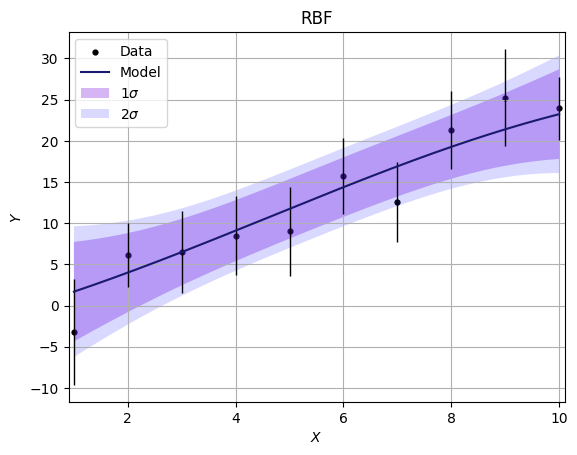

In [6]:
# Estimation of the model
k = C(1.0)*RBF()
gp = GaussianProcessRegressor(kernel=k,alpha=dy**2, n_restarts_optimizer=10)

gp.fit(x, y)

f_RBF, std_RBF = gp.predict(xs, return_std=True)

# chi^2
RBF_pred, s_RBF_pred = gp.predict(x,return_std=True)
chi2_RBF=chi2(y,RBF_pred,s_RBF_pred)

# Graph
graph(f_RBF,std_RBF)
plt.title("RBF")
plt.savefig("Linear_RBF.png")

* ### Matern:
$$
k(x,x')=\frac{1}{\Gamma(\nu)2^{\nu-1}}\left(\frac{\sqrt{2\nu}}{l}d(x,x')\right)^{\nu}K^{\nu}\left(\frac{\sqrt{2\nu}}{l}d(x,x')\right)
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html

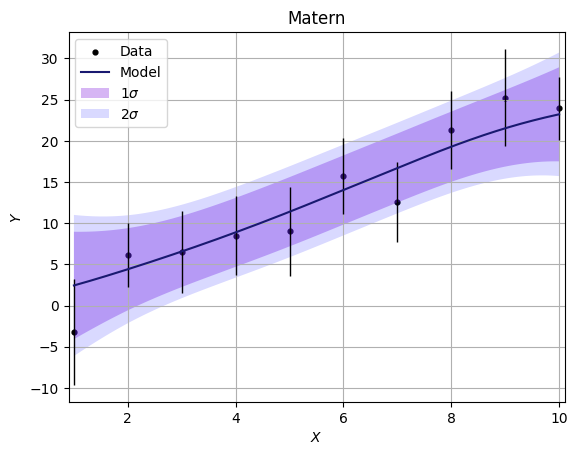

In [7]:
# Estimation of the model
k = C(1.0)*Matern()
gp = GaussianProcessRegressor(kernel=k,alpha=dy**2, n_restarts_optimizer=10)

gp.fit(x, y)

f_Matern, std_Matern = gp.predict(xs, return_std=True)

# chi^2
M_pred, s_M_pred = gp.predict(x,return_std=True)
chi2_M=chi2(y,M_pred,s_M_pred)

# Graph
graph(f_Matern,std_Matern)
plt.title("Matern")
plt.savefig("Linear_M.png")

* ### Exp-Sine-Squared:
$$
k(x,x')=\exp{\left(-\frac{2\sin^{2}{(\pi d(x,x')/p)}}{l^{2}}\right)}
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html

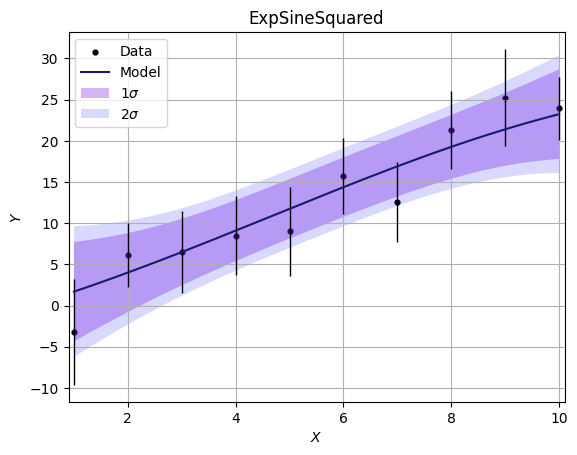

In [8]:
# Estimation of the model
k = C(1.0)*ExpSineSquared()
gp = GaussianProcessRegressor(kernel=k,alpha=dy**2, n_restarts_optimizer=10)

gp.fit(x, y)

f_ESS, std_ESS = gp.predict(xs, return_std=True)

# chi^2
ESS_pred, s_ESS_pred = gp.predict(x,return_std=True)
chi2_ESS=chi2(y,ESS_pred,s_ESS_pred)

# Graph
graph(f_ESS,std_ESS)
plt.title("ExpSineSquared")
plt.savefig("Linear_ESS.png")

* ### Dot Product:
$$
k(x,x')=\sigma_{0}^{2}+x\cdot x'
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html

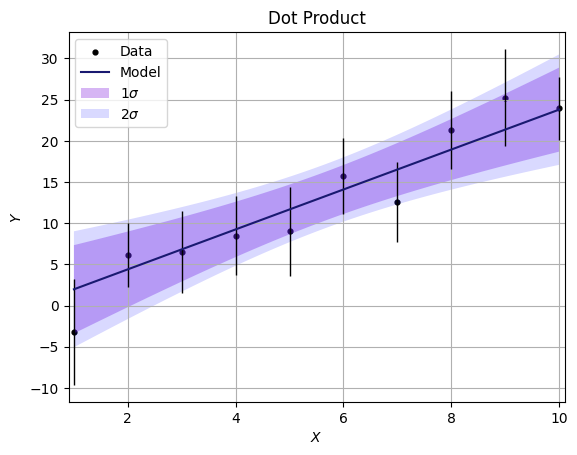

In [9]:
# Estimation of the model
k = C(0.1) * DotProduct(sigma_0=10,sigma_0_bounds="fixed")
      
gp = GaussianProcessRegressor(kernel=k,alpha=dy**2, n_restarts_optimizer=10)

gp.fit(x, y)

f_DP, std_DP = gp.predict(xs, return_std=True)

# chi^2
DP_pred, s_DP_pred = gp.predict(x,return_std=True)
chi2_DP=chi2(y,DP_pred,s_DP_pred)

# Graph
graph(f_DP,std_DP)
plt.title("Dot Product")
plt.savefig("Linear_DP.png")

* ### Rational Quadratic:
$$
k(x,x')=\left(1+\frac{d(x,x')^{2}}{2\alpha l^{2}}\right)^{-\alpha}
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html

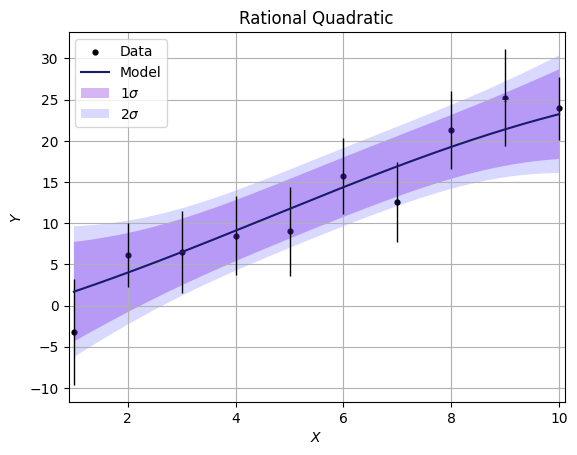

In [10]:
# Estimation of the model
k = C(1.0,(1e-4,1e5))*RationalQuadratic(alpha_bounds=(1e-5,1e7))
gp = GaussianProcessRegressor(kernel=k,alpha=dy**2, n_restarts_optimizer=10)

gp.fit(x, y)

f_RQ, std_RQ = gp.predict(xs, return_std=True)

# chi^2
RQ_pred, s_RQ_pred = gp.predict(x,return_std=True)
chi2_RQ=chi2(y,RQ_pred,s_RQ_pred)

# Graph
graph(f_RQ,std_RQ)
plt.title("Rational Quadratic")
plt.savefig("Linear_RQ.png")

## Comparison

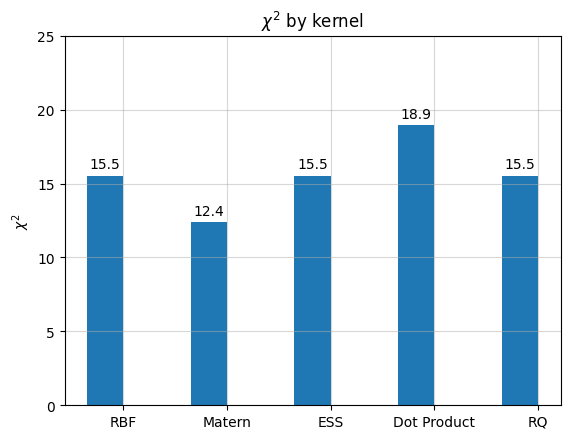

In [11]:
labels = ['RBF', 'Matern', 'ESS', 'Dot Product', 'RQ']
chi2_kernels = [chi2_RBF, chi2_M, chi2_ESS, chi2_DP, chi2_RQ]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, chi2_kernels, width)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)

ax.set_ylabel('$\chi^{2}$')
ax.set_title('$\chi^{2}$ by kernel')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.ylim(0,25)
plt.grid(alpha=0.5);

It is clear that Matern Kernel produced the minimum value of $\chi^{2}$ compared with the other kernels, then it can be concluded that it is the option that makes the best regression model in this case.

Unfortunately, the $\chi^{2}$ test does not allow to determine a priori which kernel will produce the best model, since its predictions are required to calculate the value of $\chi^{2}$. However, it is useful in order to establish with mathematical formalism what is the best model between the calculated ones.